# **Obtaining Regional Multi-Year SST Anomaly Maps from GODAS**

by Ding

In this notebook, we will preprocess the GODAS dataset and get SST anomaly maps.

Some details that have been described in the previous notebook "Obtaining Regional Multi-Year SST Maps from GODAS" will be omitted.

Similarly, we extract the ocean region next to southeastern Australia from GODAS.

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
!pip install netcdf4
!pip install h5netcdf

     |████████████████████████████████| 4.7MB 6.3MB/s 
     |████████████████████████████████| 317kB 48.3MB/s 


In [ ]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import xarray as xr
import h5netcdf.legacyapi as netCDF4

In [ ]:
pottmp_all = xr.open_mfdataset('/gdrive/My Drive/GODAS_pottmp/*.nc', decode_times=False)

pottmp_seau = pottmp_all.where(pottmp_all.lat < -35, drop=True)
pottmp_seau = pottmp_seau.where(pottmp_seau.lat > -45, drop=True)
pottmp_seau = pottmp_seau.where(pottmp_seau.lon < 155, drop=True)
pottmp_seau = pottmp_seau.where(pottmp_seau.lon > 145, drop=True)
pottmp_seau = pottmp_seau.where(pottmp_seau.level == 5.0, drop=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


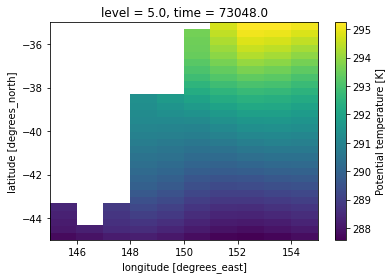

In [ ]:
pottmp_seau.pottmp.isel(level=0,time=240).plot()

In [ ]:
pottmp_seau.pottmp

,Array,Chunk
Bytes,590.40 kB,14.40 kB
Shape,"(492, 1, 30, 10)","(12, 1, 30, 10)"
Count,538 Tasks,41 Chunks
Type,float32,numpy.ndarray


In [ ]:
import numpy as np

data_set = np.zeros((492,1,30,10))
data_set[:,:,:,:] = pottmp_seau.variables['pottmp'][0:492,:,:,:]

For easily handling, drop one dimension and convert the numpy arrays into lists.

In [ ]:
data_set = np.squeeze(data_set, axis=1)

data_set_list = data_set.tolist()

In order to get the anomly map, we compute the average regional SST values by month, which returns a vector of 12 elements.

In [ ]:
monthly_average = []
monthly_average_map = []

for i in range(12):
  individual_month = data_set_list[i::12]
  average = 0
  average_map = 0
  for j in range(len(individual_month)):
    average += np.nanmean(individual_month[j])
    average_map += np.array(individual_month[j])
  monthly_average.append(average / len(individual_month))
  monthly_average_map.append(average_map / len(individual_month))

[291.3364490925174, 292.0716765738998, 291.8030082555436, 290.78703582693305, 289.53174109563656, 288.2957274672216, 287.29252478052524, 286.67249330220443, 286.64164598166633, 287.2330859924545, 288.5045015223757, 289.96177316542276]


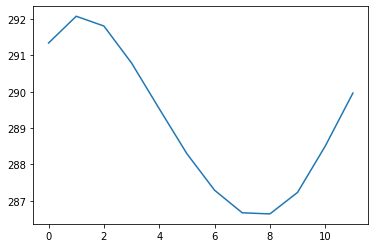

In [ ]:
print(monthly_average)

from matplotlib import pyplot

pyplot.plot(monthly_average)
pyplot.show()

Let all elements in maps by month subtract the respective monthly average SST map.

In [ ]:
anomaly_set = data_set

for i in range(12):
    anomaly_set[i::12] -= monthly_average_map[i]

In [ ]:
print(anomaly_set.shape)

(492, 30, 10)


Convert "nans" to zeroes.

In [ ]:
anomaly_set = np.where(np.isnan(anomaly_set), 0, anomaly_set)

Split the anomaly data into training and test sets.

In [ ]:
train_set = anomaly_set[:394]
test_set = anomaly_set[394:]

In [ ]:
train_set_3_list = []
train_label_list = []
test_set_3_list = []
test_label_list = []

for i in range(len(train_set) - 3):
  train_set_3_list.append([train_set[i], train_set[i+1], train_set[i+2]])
  train_label_list.append([train_set[i+3]])

for i in range(len(test_set) - 3):
  test_set_3_list.append([test_set[i], test_set[i+1], test_set[i+2]])
  test_label_list.append([test_set[i+3]])

In [ ]:
train_set_3 = np.array(train_set_3_list)
train_label = np.array(train_label_list)
test_set_3 = np.array(test_set_3_list)
test_label = np.array(test_label_list)

print(train_set_3.shape)
print(test_set_3.shape)
print(train_label.shape)
print(test_label.shape)

(391, 3, 30, 10)
(95, 3, 30, 10)
(391, 1, 30, 10)
(95, 1, 30, 10)


Save this list in Google Drive for further use.

In [ ]:
anomaly_sets_3_maps = [train_set_3.tolist(), test_set_3.tolist(), train_label.tolist(), test_label.tolist()]

In [ ]:
import json

with open('/gdrive/My Drive/GODAS/anomaly_sets_3_maps.txt', 'w') as out_file:
    json.dump(anomaly_sets_3_maps, out_file)

Prepare another set of data, the anomaly maps in the first month and the average SST values in the second month.

In [ ]:
train_set_list = []
train_label_list = []
test_set_list = []
test_label_list = []

import numpy.ma as ma

for i in range(len(train_set) - 1):
  train_set_list.append([train_set[i]])
  train_label_list.append(np.nanmean(np.where(train_set[i+1]!=0, train_set[i+1], np.nan)))

for i in range(len(test_set) - 1):
  test_set_list.append([test_set[i]])
  test_label_list.append(np.nanmean(np.where(test_set[i+1]!=0, test_set[i+1], np.nan)))

In [ ]:
anomaly_sets_1_values = [np.array(train_set_list).tolist(), np.array(test_set_list).tolist(), train_label_list, test_label_list]

In [ ]:
with open('/gdrive/My Drive/GODAS/anomaly_sets_1_values.txt', 'w') as out_file:
    json.dump(anomaly_sets_1_values, out_file)